# Import the required libraries and data set

In [ ]:
# Import the necessary libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM

# URL to import data set from GitHub.
url = 'https://raw.githubusercontent.com/.../engine.csv'

engine_df = pd.read_csv(url)

# View DataFrame and perform EDA

In [ ]:
# Display the first few rows of the data set.
print(engine_df.shape)
engine_df.head()

(19535, 6)


,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
0,682,2.391656,4.617196,2.848982,76.272417,69.884609
1,605,5.466877,6.424361,5.727520,73.222679,74.907314
2,658,3.434232,3.680896,1.678708,88.089916,78.704806
3,749,2.094656,7.120927,1.639670,77.661625,82.386700
4,676,3.538228,5.956472,3.225336,75.226352,67.153220


In [ ]:
engine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19535 entries, 0 to 19534
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Engine rpm        19535 non-null  int64  
 1   Lub oil pressure  19535 non-null  float64
 2   Fuel pressure     19535 non-null  float64
 3   Coolant pressure  19535 non-null  float64
 4   lub oil temp      19535 non-null  float64
 5   Coolant temp      19535 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 915.8 KB


In [ ]:
engine_df.isnull().sum()

Engine rpm          0
Lub oil pressure    0
Fuel pressure       0
Coolant pressure    0
lub oil temp        0
Coolant temp        0
dtype: int64

In [ ]:
engine_df = engine_df.drop_duplicates()
print(engine_df.shape)

(19535, 6)


# Descriptive statistics


In [ ]:
# Compute descriptive statistics.
engine_df.describe(percentiles=[.25, .5, .75, .95]).round(2)

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
count,19535.00,19535.00,19535.00,19535.00,19535.00,19535.00
mean,791.24,3.30,6.66,2.34,77.64,78.43
std,267.61,1.02,2.76,1.04,3.11,6.21
min,61.00,0.00,0.00,0.00,71.32,61.67
25%,593.00,2.52,4.92,1.60,75.73,73.90
50%,746.00,3.16,6.20,2.17,76.82,78.35
75%,934.00,4.06,7.74,2.85,78.07,82.92
95%,1324.00,5.06,12.21,4.44,84.94,88.61
max,2239.00,7.27,21.14,7.48,89.58,195.53


In [ ]:
# Compute median values.
median_values = engine_df.median()
median_values

Engine rpm          746.000000
Lub oil pressure      3.162035
Fuel pressure         6.201720
Coolant pressure      2.166883
lub oil temp         76.817350
Coolant temp         78.346662
dtype: float64

In [ ]:
# Idenitfying the range values beyond the 95th percentile.

def print_percentile_info(feature_name, pct):
    percentile_value = engine_df[feature_name].quantile(pct)

    print("{0} Percentile vlaue for '{1}' is {2}".format(pct * 100, feature_name, percentile_value.round(2)))

    high_percentile_df = engine_df[engine_df[feature_name] >= percentile_value][feature_name]

    print("Number of '{0}' readings above {1} percentile is {2}".format(feature_name, pct * 100, high_percentile_df.shape[0]))
    print(high_percentile_df)
    print("\n")

for column in engine_df.columns:
    print_percentile_info(column, .95)

95.0 Percentile vlaue for 'Engine rpm' is 1324.0
Number of 'Engine rpm' readings above 95.0 percentile is 978
23       1411
35       1374
73       1438
76       1399
99       1347
         ... 
19472    1463
19484    1383
19495    1424
19522    1329
19529    1581
Name: Engine rpm, Length: 978, dtype: int64


95.0 Percentile vlaue for 'Lub oil pressure' is 5.06
Number of 'Lub oil pressure' readings above 95.0 percentile is 977
1        5.466877
7        5.495972
12       5.336469
17       5.963439
52       5.618394
           ...   
19299    5.507376
19360    5.064814
19372    5.165195
19451    5.651968
19519    5.076495
Name: Lub oil pressure, Length: 977, dtype: float64


95.0 Percentile vlaue for 'Fuel pressure' is 12.21
Number of 'Fuel pressure' readings above 95.0 percentile is 977
6        15.499680
7        13.114658
9        21.138326
72       13.739860
90       13.944291
           ...    
19433    14.431486
19438    15.310746
19448    16.472671
19449    13.110441
19467    14.5

# Visualise the data to determine the distribution and extreme values.

array([[<Axes: title={'center': 'Engine rpm'}>,
        <Axes: title={'center': 'Lub oil pressure'}>,
        <Axes: title={'center': 'Fuel pressure'}>],
       [<Axes: title={'center': 'Coolant pressure'}>,
        <Axes: title={'center': 'lub oil temp'}>,
        <Axes: title={'center': 'Coolant temp'}>]], dtype=object)

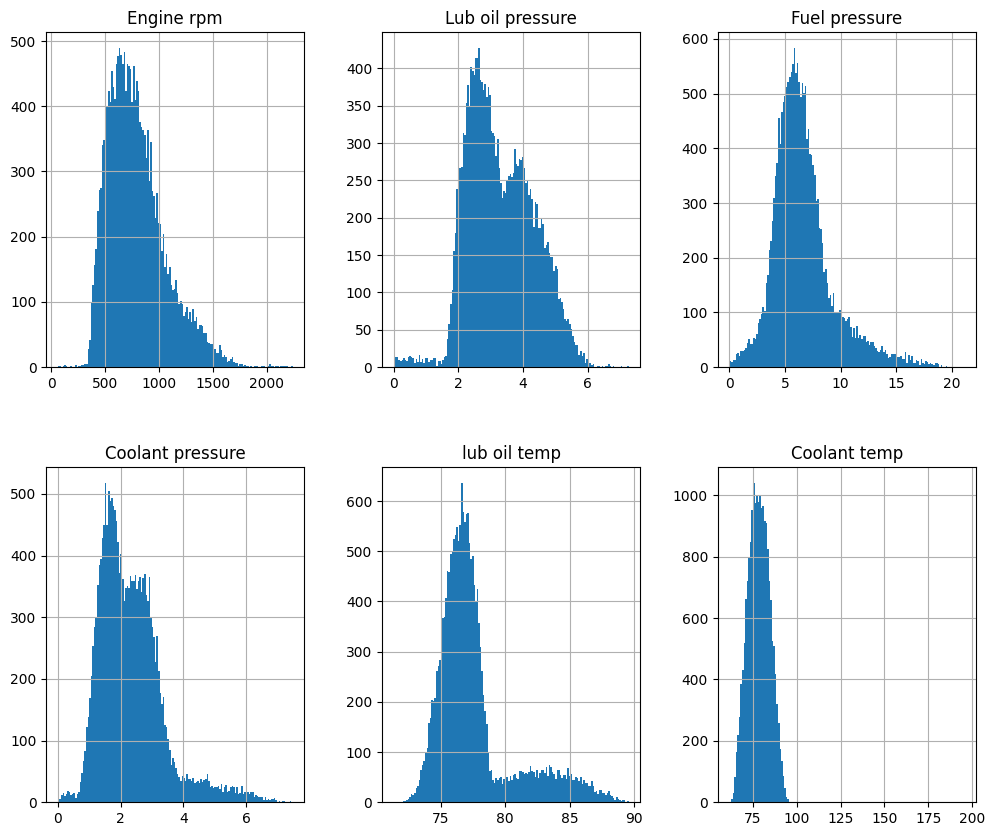

In [ ]:
# Visualise data with histogram.
engine_df.hist(figsize=(12, 10), bins=150, layout=(2,3))


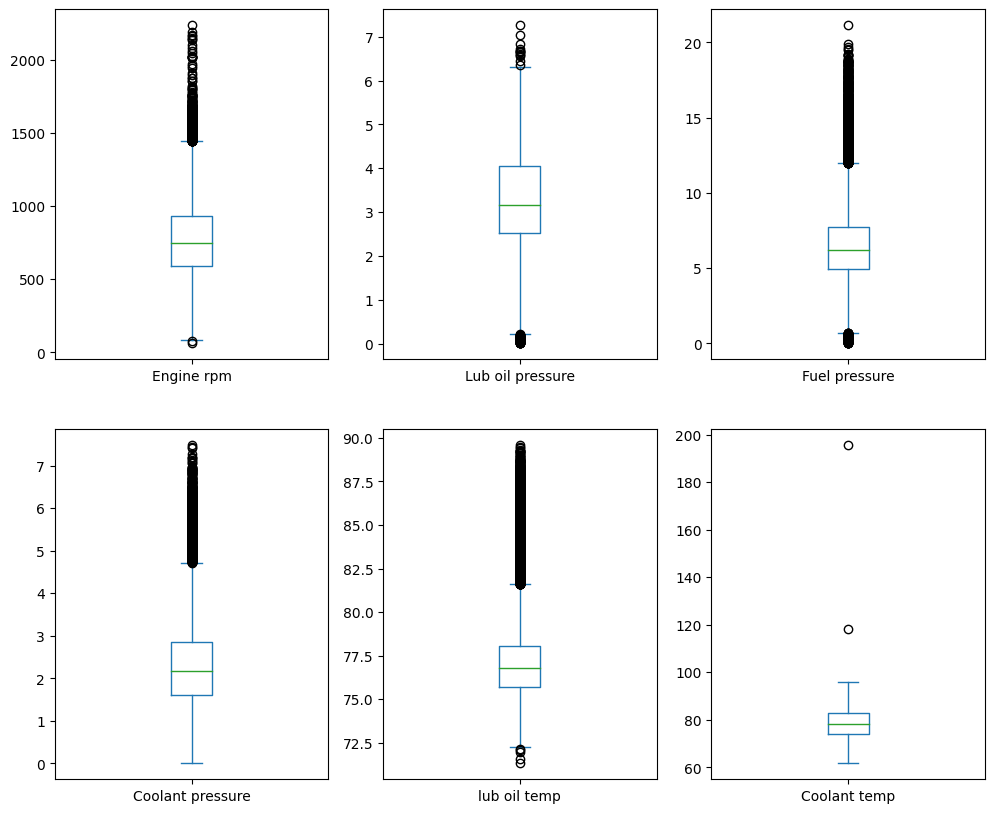

In [ ]:
# Visualise data with boxplot.
engine_df.plot(kind='box', subplots=True, layout=(2,3), sharex=False, sharey=False, figsize=(12, 10))
plt.show()

# Anomaly detection with a statistical method: Interquartile Range (IQR)


In [ ]:
iqr_engine_df = engine_df.copy()

def is_outlier(row, feature_name, upper, lower):
    return 1 if (row[feature_name] > upper) | (row[feature_name] < lower) else 0

def calculate_iqr(feature_name):
    # Calculate the quantiles.

    print("Feature name:", feature_name)
    feature = iqr_engine_df[feature_name].sort_values()

    # Compute and print quantiles.
    q1 = feature.quantile(0.25)
    q3 = feature.quantile(0.75)
    print("The value of Q1 is:", q1)
    print("The value of Q3 is:", q3)

    # Compute and print the IQR.
    iqr = q3 - q1
    print("The value of IQR is:",iqr)

    # Compute and print upper and lower limits.
    lower = q1-1.5*iqr
    upper = q3+1.5*iqr
    print("Upper limit: ", upper)
    print("Lower limit: ", lower)

    print("-------------------------------------\n")

    anomaly_feature = column + ' Anomaly'
    # Apply the function to each row in the DataFrame. Mark each datapoint as an outlier or not
    iqr_engine_df[anomaly_feature] = iqr_engine_df.apply(is_outlier, args=(feature_name, upper, lower), axis=1)


for column in engine_df.columns:
    calculate_iqr(column)

Feature name: Engine rpm
The value of Q1 is: 593.0
The value of Q3 is: 934.0
The value of IQR is: 341.0
Upper limit:  1445.5
Lower limit:  81.5
-------------------------------------

Feature name: Lub oil pressure
The value of Q1 is: 2.5188147159999996
The value of Q3 is: 4.0552715195
The value of IQR is: 1.5364568035000001
Upper limit:  6.35995672475
Lower limit:  0.21412951074999942
-------------------------------------

Feature name: Fuel pressure
The value of Q1 is: 4.916886097
The value of Q3 is: 7.7449733335
The value of IQR is: 2.8280872365
Upper limit:  11.987104188250001
Lower limit:  0.6747552422499998
-------------------------------------

Feature name: Coolant pressure
The value of Q1 is: 1.6004658630000002
The value of Q3 is: 2.848839661
The value of IQR is: 1.2483737979999998
Upper limit:  4.7214003579999995
Lower limit:  -0.27209483399999956
-------------------------------------

Feature name: lub oil temp
The value of Q1 is: 75.72599023000001
The value of Q3 is: 78.0716

In [ ]:
iqr_engine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19535 entries, 0 to 19534
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Engine rpm                19535 non-null  int64  
 1   Lub oil pressure          19535 non-null  float64
 2   Fuel pressure             19535 non-null  float64
 3   Coolant pressure          19535 non-null  float64
 4   lub oil temp              19535 non-null  float64
 5   Coolant temp              19535 non-null  float64
 6   Engine rpm Anomaly        19535 non-null  int64  
 7   Lub oil pressure Anomaly  19535 non-null  int64  
 8   Fuel pressure Anomaly     19535 non-null  int64  
 9   Coolant pressure Anomaly  19535 non-null  int64  
 10  lub oil temp Anomaly      19535 non-null  int64  
 11  Coolant temp Anomaly      19535 non-null  int64  
dtypes: float64(5), int64(7)
memory usage: 1.8 MB


In [ ]:
# Calculate total anomaly per sample
iqr_engine_df['TotalAnomaly'] = (iqr_engine_df['Engine rpm Anomaly'] + iqr_engine_df['Lub oil pressure Anomaly'] +
                                iqr_engine_df['Fuel pressure Anomaly'] + iqr_engine_df['Coolant pressure Anomaly'] +
                                 iqr_engine_df['lub oil temp Anomaly'] + iqr_engine_df['Coolant temp Anomaly'])

In [ ]:
iqr_engine_df[iqr_engine_df['TotalAnomaly'] >= 2][['Engine rpm Anomaly', 'Lub oil pressure Anomaly',
                                                   'Fuel pressure Anomaly', 'Coolant pressure Anomaly',
                                                   'lub oil temp Anomaly', 'Coolant temp Anomaly', 'TotalAnomaly']]

,Engine rpm Anomaly,Lub oil pressure Anomaly,Fuel pressure Anomaly,Coolant pressure Anomaly,lub oil temp Anomaly,Coolant temp Anomaly,TotalAnomaly
113,1,0,0,0,1,0,2
122,1,0,0,0,1,0,2
131,0,0,1,0,1,0,2
144,1,0,0,0,1,0,2
148,1,0,0,0,1,0,2
...,...,...,...,...,...,...,...
19236,0,0,1,0,1,0,2
19306,0,0,0,1,1,0,2
19328,0,0,0,1,1,0,2
19343,1,0,0,0,1,0,2


In [ ]:
iqr_engine_df[iqr_engine_df['TotalAnomaly'] >= 3][['Engine rpm Anomaly', 'Lub oil pressure Anomaly',
                                                   'Fuel pressure Anomaly', 'Coolant pressure Anomaly',
                                                   'lub oil temp Anomaly', 'Coolant temp Anomaly', 'TotalAnomaly']]

,Engine rpm Anomaly,Lub oil pressure Anomaly,Fuel pressure Anomaly,Coolant pressure Anomaly,lub oil temp Anomaly,Coolant temp Anomaly,TotalAnomaly
685,1,0,0,1,1,0,3
1674,0,0,1,1,1,0,3
5429,0,0,1,1,1,0,3
5844,0,0,1,1,1,0,3
6254,0,0,1,1,1,0,3
10111,0,0,1,1,1,0,3
11395,1,0,0,1,1,0,3
12282,0,0,1,1,1,0,3
14056,1,0,1,0,1,0,3
14802,1,0,1,0,1,0,3


**Interquartile Range (IQR): Thoughts and Oberservations:**

The interquartile range (IQR) method has identified 11 samples as anomalies based on 3 features falling under an outlier category. There are no sample that has more than 3 outlying features. This is way below the expected number of anomalies that were expected as per the business insight of 1% to 5%.

Based on 2 or more features, IQR indicates 422 samples as anomalies. This falls within the expected range and therefore a more appropriate model if IRQ was to be adopted.

# Anomaly detection with ML models

In [ ]:
# Perform feature scaling to prepare the data for ML algorithms.

engine_df_Scaled = engine_df.copy()

# As the sample reading seems to be all skewed, we will use MinMaxScalar to normalise the data.
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

def normalise_features(feature_name):
  engine_df_Scaled[feature_name] = min_max_scaler.fit_transform(engine_df[[feature_name]])

for column in engine_df_Scaled.columns:
  normalise_features(column)

engine_df_Scaled.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
0,0.285124,0.328864,0.218310,0.380751,0.271126,0.061345
1,0.249770,0.752321,0.303815,0.765787,0.104098,0.098868
2,0.274105,0.472427,0.174009,0.224214,0.918347,0.127239
3,0.315886,0.287968,0.336773,0.218992,0.347210,0.154745
4,0.282369,0.486747,0.281677,0.431092,0.213835,0.040939


In [ ]:
# Compute descriptive statistics.
engine_df_Scaled.describe(percentiles=[.25, .5, .75, .95]).round(2)

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
count,19535.00,19535.00,19535.00,19535.00,19535.00,19535.00
mean,0.34,0.45,0.31,0.31,0.35,0.13
std,0.12,0.14,0.13,0.14,0.17,0.05
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.24,0.35,0.23,0.21,0.24,0.09
50%,0.31,0.43,0.29,0.29,0.30,0.12
75%,0.40,0.56,0.37,0.38,0.37,0.16
95%,0.58,0.70,0.58,0.59,0.75,0.20
max,1.00,1.00,1.00,1.00,1.00,1.00


array([[<Axes: title={'center': 'Engine rpm'}>,
        <Axes: title={'center': 'Lub oil pressure'}>,
        <Axes: title={'center': 'Fuel pressure'}>],
       [<Axes: title={'center': 'Coolant pressure'}>,
        <Axes: title={'center': 'lub oil temp'}>,
        <Axes: title={'center': 'Coolant temp'}>]], dtype=object)

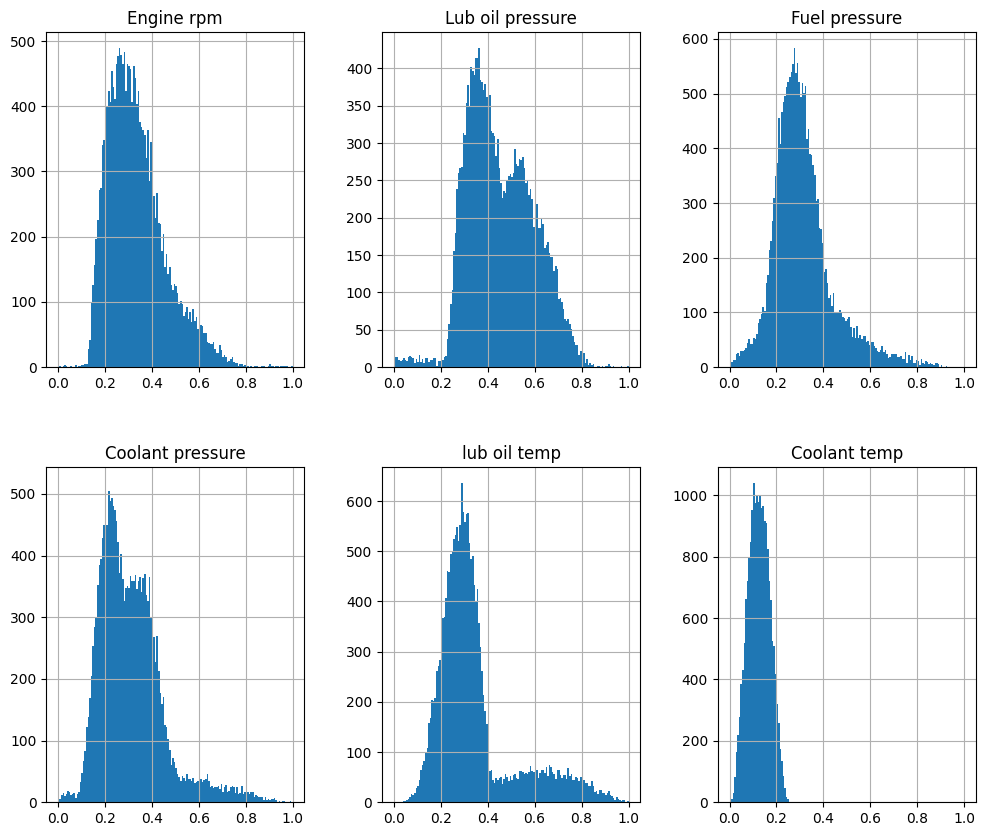

In [ ]:
# Visualise scaled data with histogram.
engine_df_Scaled.hist(figsize=(12, 10), bins=150, layout=(2,3))

In [ ]:
# Apply PCA to reduce the features to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(engine_df_Scaled)

# Compare the shape of the normalised and PCA data.
print("Normalised data: ", engine_df_Scaled.shape)
print("PCA data: ", X_pca.shape)

Normalised data:  (19535, 6)
PCA data:  (19535, 2)


In [ ]:
# Visualise the reduced data in 2D.
def plot_pca(X, title, y_subset):
    plt.figure(figsize=(10, 6))
    #for i in [1, -1]:
    for i in sorted(np.unique(y_subset), reverse=True):
        plt.scatter(X[y_subset == i, 0],
                    X[y_subset == i, 1],
                    label=str(i))
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()


# Anomaly detection using one-class SVM

In [ ]:
# Visualise the data
def plot_oneclassSVM_model(model, X_scaled, y_pred, title):
    # Create a grid for plotting decision boundaries and anomaly detection.
    xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    anomalycount = np.count_nonzero(y_pred == -1)

    # Plot setup.
    plt.figure(figsize=(10, 6))
    plt.title(title + " - Anomalies: {0}".format(anomalycount))

    # Plot the decision function levels and decision boundary.
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu, alpha=0.8)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')  # Decision boundary
    plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred', alpha=0.5)  # Anomaly regions

    # Plot also the data points, using different markers for normals and anomalies.
    sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=np.where(y_pred == 1, 'Normal', 'Anomaly'),
                    style=np.where(y_pred == -1, 'Anomaly', 'Normal'), markers={'Anomaly': 'X', 'Normal': 'o'},
                    palette={'Normal': 'deepskyblue', 'Anomaly': 'red'}, alpha=0.6, edgecolor='k')

    # Plot aesthetics.
    plt.axis('tight')
    plt.xlim((-3, 3))
    plt.ylim((-3, 3))
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

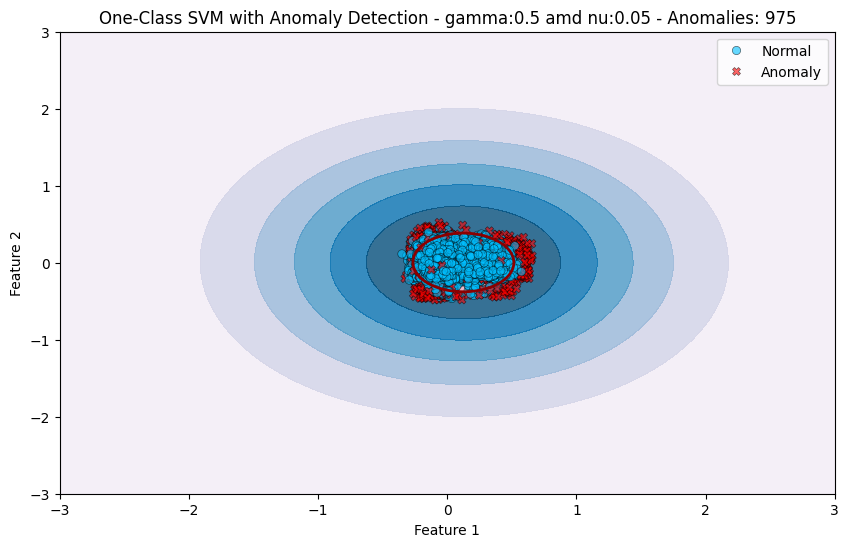

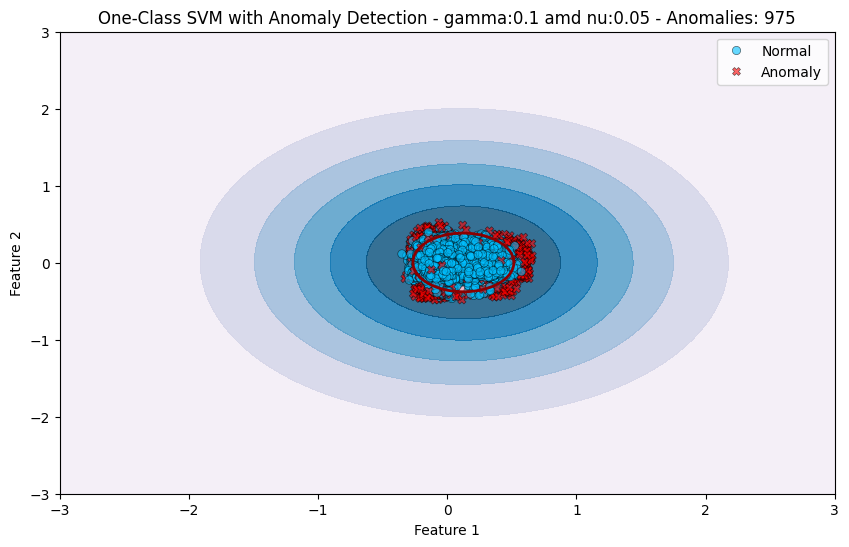

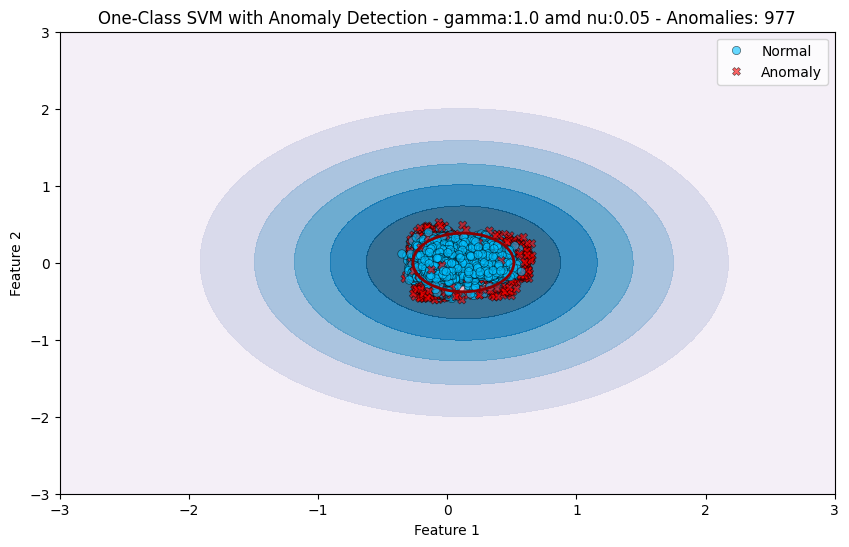

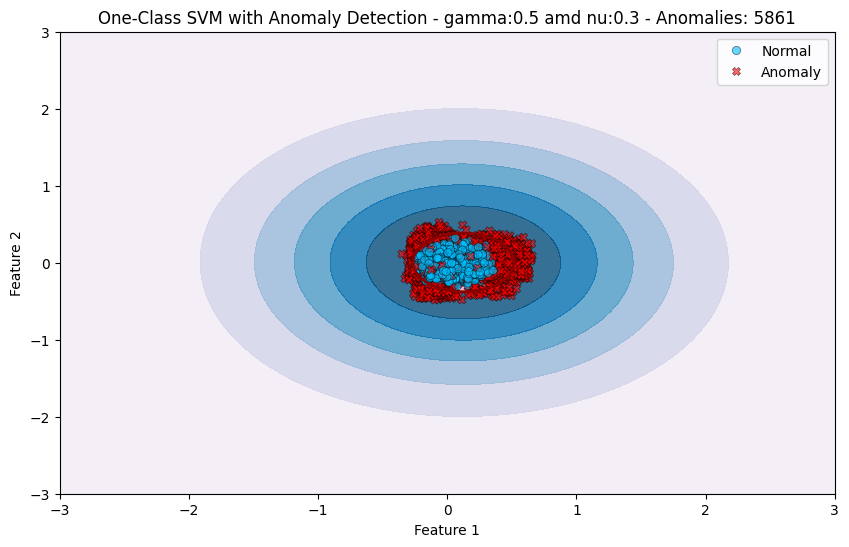

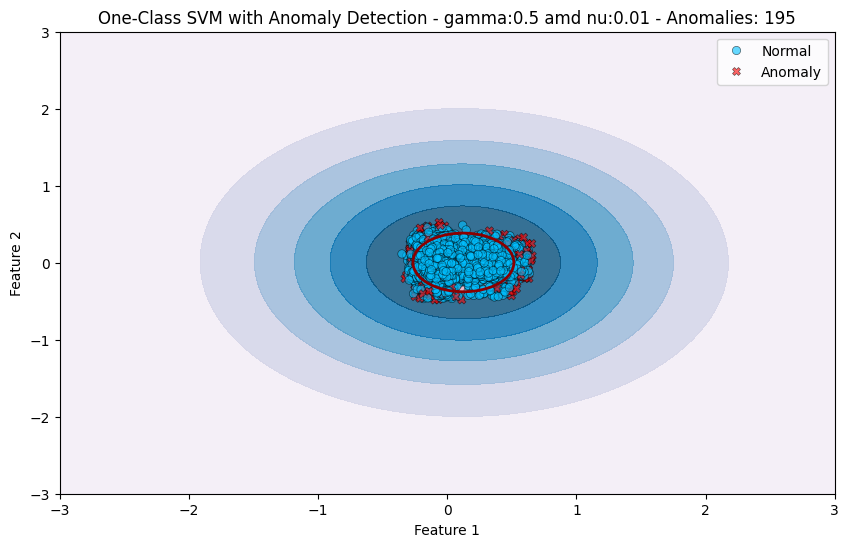

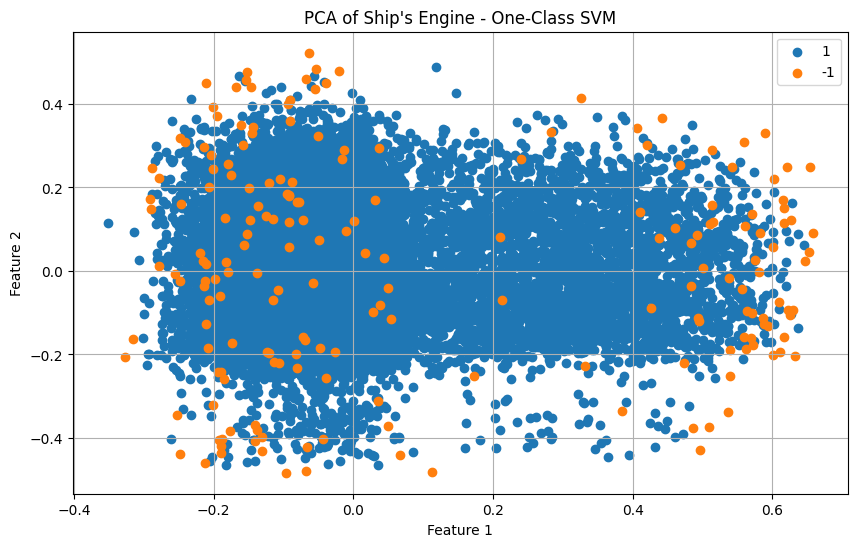

In [ ]:
engine_df_OneClassSVM = engine_df_Scaled.to_numpy()

model_pca = OneClassSVM(kernel='rbf', gamma=0.5, nu=0.05)
model_pca.fit(X_pca)


def fit_predict_OneClassSVM(kernel, gamma, nu):
  model = OneClassSVM(kernel=kernel, gamma=gamma, nu=nu)
  model.fit(engine_df_OneClassSVM)
  y_pred = model.predict(engine_df_OneClassSVM)

  plot_oneclassSVM_model(model_pca, X_pca, y_pred, "One-Class SVM with Anomaly Detection - gamma:{0} amd nu:{1}".format(gamma, nu))

  return y_pred

fit_predict_OneClassSVM('rbf', 0.5, 0.05)
fit_predict_OneClassSVM('rbf', 0.1, 0.05)
fit_predict_OneClassSVM('rbf', 1.0, 0.05)
fit_predict_OneClassSVM('rbf', 0.5, 0.3)
y_pred = fit_predict_OneClassSVM('rbf', 0.5, 0.01)

plot_pca(X_pca, "PCA of Ship's Engine - One-Class SVM", y_pred)


**One-Class SVM: Thoughts and Oberservations:**

Initially the features were Normalised (MinMaxScaler) as the data distribution of all features seemed skewed. Anomalies were then identified using one-class SVM using various parameter values for **gamma** and **nu**.

When **nu** was kept constant at .05 and **gamma** was changed, the number of anomalies did not change by much and kept around 980. This is around the 5% anomalies that business insight had provided.

When **gamma** was kept constant at .5 and **nu** was changed, the number of anomalies changed and predicted 199 anomalies at **nu** = 0.01. This is around the 1% anomalies that business insight had provided.

One-Class SVM is able to predict anomalies between 1% and 5% by varying the **nu** parameters.

**Note**: The normal data points and anomalies seem to overlap as the anomalies are predicted with all 6 features while it is plotted over 2 features deduced using PCA. Having said that the anomalies are mainly towards the edges.

# Anomaly detection using Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

X_pca

array([[-0.07613435, -0.15533677],
       [-0.27824719,  0.22314841],
       [ 0.5753444 , -0.00113707],
       ...,
       [-0.12254681, -0.09161525],
       [-0.02859666, -0.10246243],
       [-0.00898779, -0.11570027]])

[ 0.10138956 -0.05489974 -0.00345338 ...  0.02893474  0.09809211
  0.1105325 ]
Only Anomalies: (1954, 3)
       Feature 1  Feature 2  anomaly
1      -0.278247   0.223148       -1
2       0.575344  -0.001137       -1
7       0.001558   0.369525       -1
13      0.565802   0.152702       -1
16      0.485322  -0.167065       -1
...          ...        ...      ...
19433  -0.149246   0.006875       -1
19448  -0.108628   0.307940       -1
19451  -0.079559   0.293234       -1
19467  -0.101392  -0.014667       -1
19516   0.414346  -0.106375       -1

[1954 rows x 3 columns]


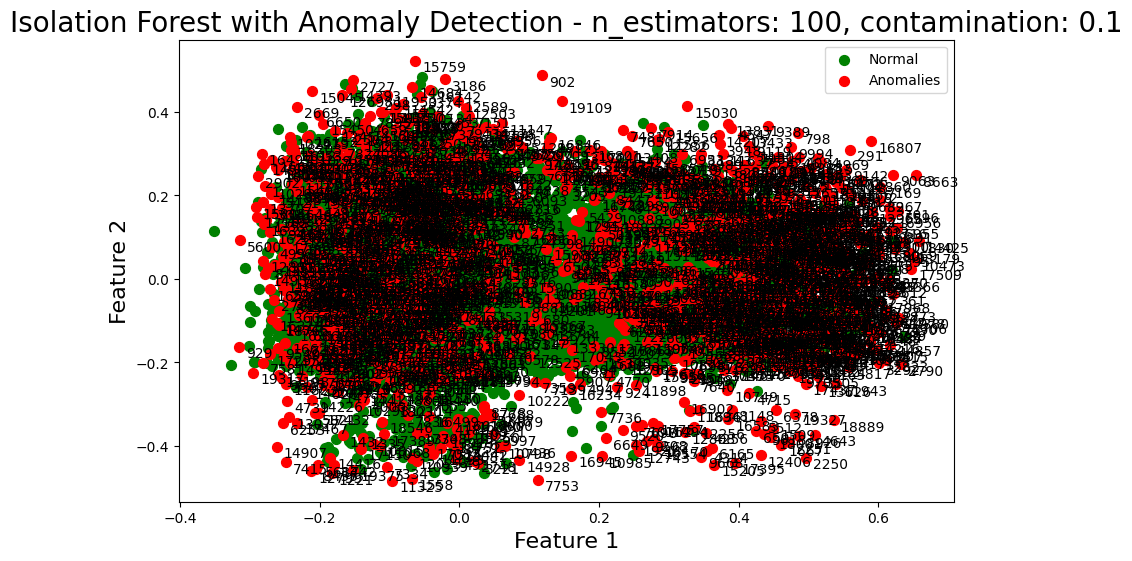

array([ 1, -1, -1, ...,  1,  1,  1])

In [ ]:
# Visualise the data
def plot_iso_forest(X_pca, n_estimators, contamination, random_state):

  X_pca_df = pd.DataFrame(X_pca, columns=['Feature 1', 'Feature 2'])

  engine_df_IsolationForest = engine_df.to_numpy()

  iso_forest = IsolationForest(n_estimators=n_estimators, contamination=contamination, random_state=random_state)
  iso_forest.fit(engine_df_IsolationForest)

  scores_pred = iso_forest.decision_function(engine_df_IsolationForest)
  print(scores_pred)

  # Predict the anomalies (1 for not anomaly, -1 for anomaly).
  y_pred = iso_forest.predict(engine_df_IsolationForest)


  # Add anomaly column to DataFrame.
  X_pca_df['anomaly'] = y_pred
  # View output.
  #print(engine_df_IsolationForest)

  # Display anomalies in the DataFrame.
  only_anomalies = X_pca_df[X_pca_df.anomaly == -1]

  # View output.
  print("Only Anomalies: {0}".format(only_anomalies.shape))
  print(only_anomalies)

  # Visualise the data points.

  plt.figure(figsize=(10, 6))

  plt.scatter(X_pca_df[X_pca_df.anomaly == 1].iloc[:, 0],
              X_pca_df[X_pca_df.anomaly == 1].iloc[:, 1],
              label='Normal',
              c='green',
              s=50)

  # Highlight anomalies.
  plt.scatter(X_pca_df[X_pca_df.anomaly == -1].iloc[:, 0],
              X_pca_df[X_pca_df.anomaly == -1].iloc[:, 1],
              c='red', s=50, label='Anomalies')

  # Add labels for anomalies.
  for i in only_anomalies.index:
      plt.annotate(i, (X_pca[i, 0], X_pca[i, 1]),
                  textcoords="offset points",
                  xytext=(5, -5),
                  ha='left', va='center')

  # Add title, labels, and legend.

  title = 'Isolation Forest with Anomaly Detection - n_estimators: {0}, contamination: {1}'.format(n_estimators, contamination, random_state)
  plt.title(title, fontsize=20)
  plt.xlabel('Feature 1', fontsize=16)
  plt.ylabel('Feature 2', fontsize=16)
  plt.legend()

  # View plot.
  plt.show()

  return y_pred

plot_iso_forest(X_pca, n_estimators=100, contamination=0.1, random_state=42)

[ 0.1253332  -0.0309561   0.02049026 ...  0.05287838  0.12203575
  0.13447615]
Only Anomalies: (977, 3)
       Feature 1  Feature 2  anomaly
1      -0.278247   0.223148       -1
17     -0.010455   0.331849       -1
35      0.273942  -0.034664       -1
113     0.434124   0.000615       -1
131     0.517972   0.076115       -1
...          ...        ...      ...
19343   0.434170  -0.098078       -1
19370   0.599128   0.006571       -1
19375  -0.152152  -0.457112       -1
19433  -0.149246   0.006875       -1
19516   0.414346  -0.106375       -1

[977 rows x 3 columns]


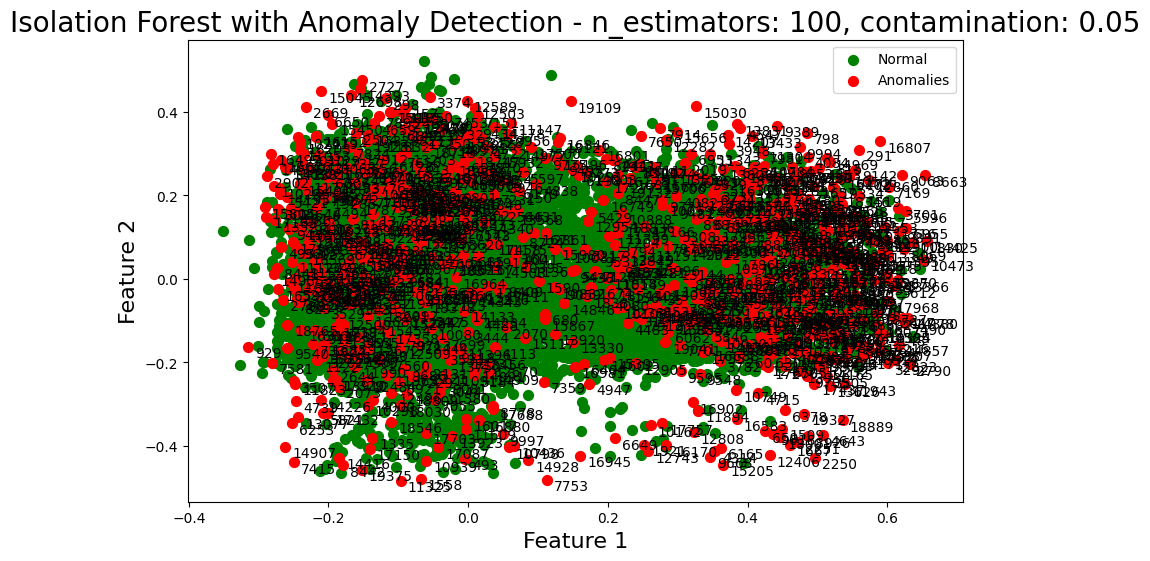

array([ 1, -1,  1, ...,  1,  1,  1])

In [ ]:
plot_iso_forest(X_pca, n_estimators=100, contamination=0.05, random_state=42)

[ 0.14083659 -0.01545271  0.03599366 ...  0.06838178  0.13753914
  0.14997954]
Only Anomalies: (587, 3)
       Feature 1  Feature 2  anomaly
1      -0.278247   0.223148       -1
17     -0.010455   0.331849       -1
144     0.540055  -0.189601       -1
157    -0.090255   0.410632       -1
160     0.066609   0.063685       -1
...          ...        ...      ...
19328   0.417503   0.027337       -1
19334   0.523004   0.219701       -1
19343   0.434170  -0.098078       -1
19375  -0.152152  -0.457112       -1
19433  -0.149246   0.006875       -1

[587 rows x 3 columns]


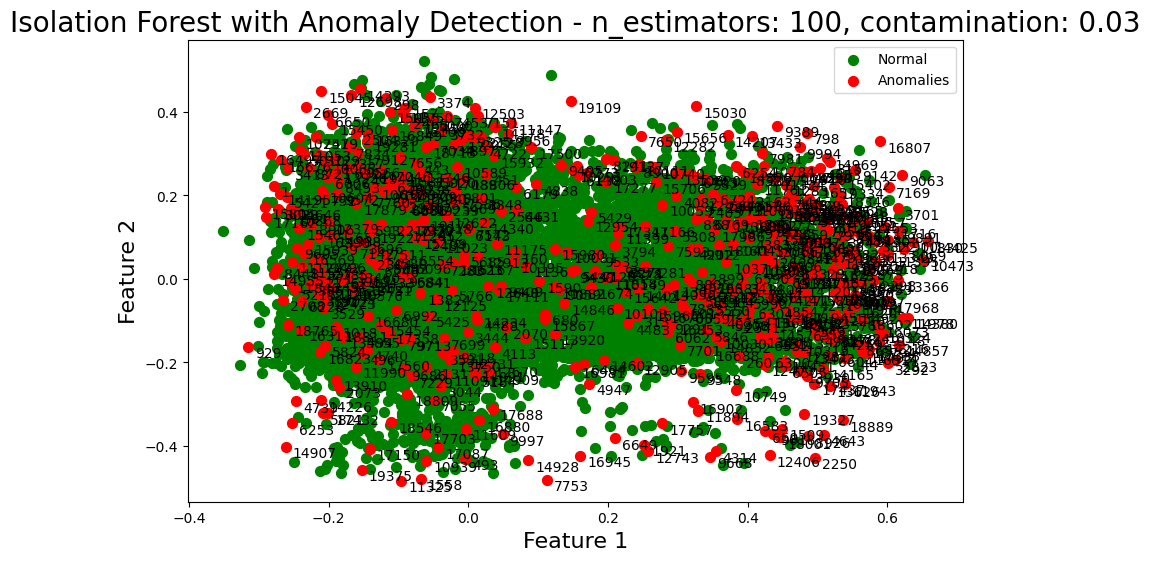

array([ 1, -1,  1, ...,  1,  1,  1])

In [ ]:
plot_iso_forest(X_pca, n_estimators=100, contamination=0.03, random_state=42)

[0.1678182  0.0115289  0.06297527 ... 0.09536339 0.16452075 0.17696115]
Only Anomalies: (196, 3)
       Feature 1  Feature 2  anomaly
17     -0.010455   0.331849       -1
144     0.540055  -0.189601       -1
157    -0.090255   0.410632       -1
249    -0.203059  -0.007081       -1
298    -0.118007   0.433601       -1
...          ...        ...      ...
18889   0.535961  -0.337952       -1
19185   0.560606   0.108165       -1
19281  -0.145293   0.331149       -1
19343   0.434170  -0.098078       -1
19375  -0.152152  -0.457112       -1

[196 rows x 3 columns]


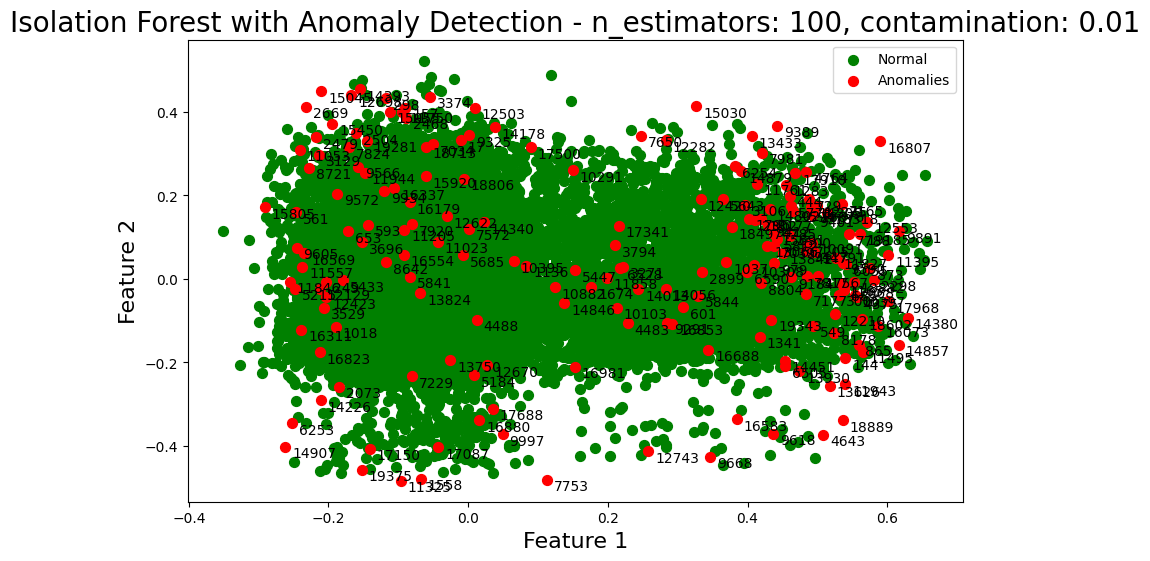

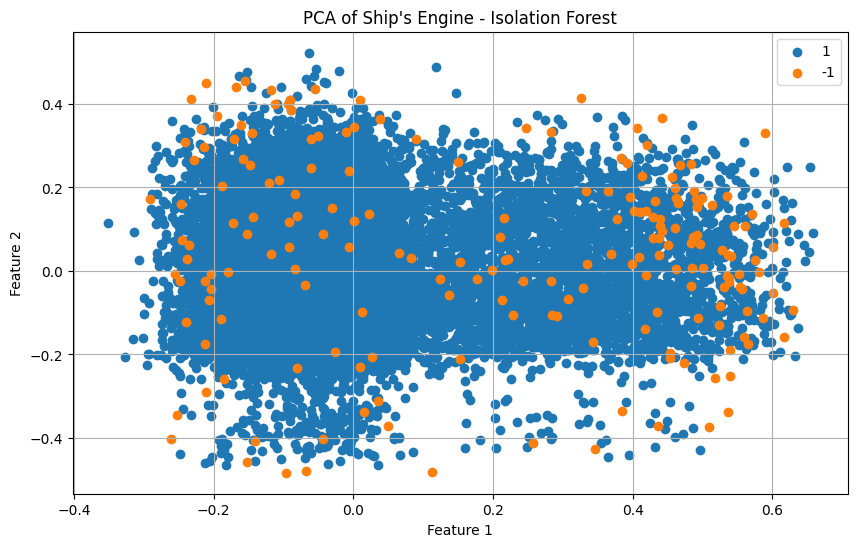

In [ ]:
y_pred = plot_iso_forest(X_pca, n_estimators=100, contamination=0.01, random_state=42)
plot_pca(X_pca, "PCA of Ship's Engine - Isolation Forest", y_pred)

**Isolation Forest: Thoughts and Oberservations:**

Initially the features were Normalised (MinMaxScaler) as the data distribution of all features seemed skewed. Anomalies were then identified using Isolation Forest using various parameter values for **contamination**.

The n_estimators parameter was kept constant at 100 throughout the modelling.

When **contamination** was set at .05 the number of anomalies predicted was 977 matching the 5% anomalies that business insight had provided.

When **contamination** was set at .01 the number of anomalies predicted was 196 closer the 1% anomalies that business insight had provided.

Isolation Forest is able to predict anomalies between 1% and 5% with corresponding values of **contamination** parameter.

**Note**: The normal data points and anomalies seem to overlap as the anomalies are predicted with all 6 features while it is plotted over 2 features deduced using PCA.

# Reflection

> **Descriptive statistics** did not show any oddity. Data was clean with no null values or duplicates. Mean and median seemed very close, but the visualisation (histogram) showed that the distribution was skewed. The box plot also showed that there were quite a lot of outliers on all features except **Coolant temp**. Based on the skewed distribution, data was scaled using MinMaxScaler to normalise them.

> **Interquartile range (IQR)** method identified 11 samples as anomalies based on 3 or more features falling under an outlier category and 422 as anomalies based on 2 or more features falling under an outlier category.

> Both **One-class SVM** and **Isolation Forest** models were able to predict anomalies in the range from 1% to 5%.

> All 3 methods predicted anomalies within the expected range. To make a definitive choice between the 3 models, their results will have to be verified by a domain expert and determined which of the 3 models made the most accurate predictions.

### Reference:
Devabrat, M., 2022. Predictive Maintenance on Ship's Main Engine using AI. Available at: https://dx.doi.org/10.21227/g3za-v415. [Accessed 5 March 2024]